1. In the implementation of QFT for $|0010\rangle$ we use `QFT(4, inverse=False)` but in the second part we use `QFT(4, inverse=True)` to find the frequency of the function. Give a good explainantion as to why we have to use inverse QFT for finding freq. of e^2ix.

for $|0010\rangle$ we use `QFT(4, inverse=False)` where we change the quantum state from its original basis state to the Fourier state. In this state all outcomes are equally probabable. Basically the Hadamard gates and controlled rotations make it so that all outcomes have magnitude but different phase.

for $e^2ix$ we use `QFT(4, inverse=True)`, where $e^2ix$ is already in the Fourier basis (frequency domain) but what we need is a measureable. To make these amplitudes into measureables we have to convert it back to our computational basis which is done using the inverse Quantum Fourier Transform.

In [269]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import numpy as np
import math
from fractions import Fraction
import random

2. Implement Fourier Transform of $sin(2x)$ and $sin(8x)$ similarly as to what I have done for $e^{2ix}$ and plot the histogram of the results.

In [270]:
simulator = AerSimulator()


In [271]:
def convertor(n, values):
    qc_exp = QuantumCircuit(n)
    qc_exp.initialize(values, range(n))
    qft_circ_inv = QFT(n, inverse=True)
    qc_exp.compose(qft_circ_inv, inplace=True)
    qc_exp.measure_all()
    qc_exp.draw('mpl')
    qc_exp_comp = transpile(qc_exp, simulator)
    result = simulator.run(qc_exp_comp, shots=9600).result()
    counts = result.get_counts()
    print("Measurement counts:", counts)
    counts_copy = counts.copy()
    return counts_copy

In [272]:
# Step 1: Discretize e^(2ix) into 2^4 = 16 points
n_qubits = 4
num_points = 2**n_qubits
x = np.linspace(0, 2*np.pi, num_points, endpoint=False)



Measurement counts: {'1110': 4774, '0010': 4826}


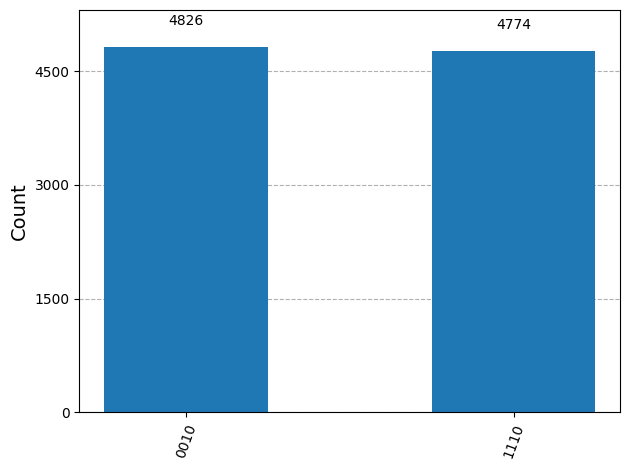

In [273]:
func_values = np.sin(2*x)  

# Normalize the values to fit as amplitudes
normalized_values = func_values / np.linalg.norm(func_values)
counts = convertor(n_qubits, normalized_values)
plot_histogram(counts)

3. The histogram for $sin(2x)$ shows peaks at 2 and 14. Explain why this makes sense theoretically, especially the peak at 14.


Since $sin(2x)$ is a pure frequency, we can easily convert it to Fourier basis. Having a frequency of $2$, the Fourier state of it is made of $|2\rangle$ and the state corresponding to $-2$ which is $|16-2\rangle$ $=$ $|14\rangle$

Measurement counts: {'1010': 24, '0110': 24, '0000': 158, '0101': 665, '1001': 342, '1100': 1195, '0100': 1193, '0001': 43, '0011': 840, '0111': 335, '1011': 645, '1110': 149, '1000': 2930, '0010': 152, '1111': 42, '1101': 863}


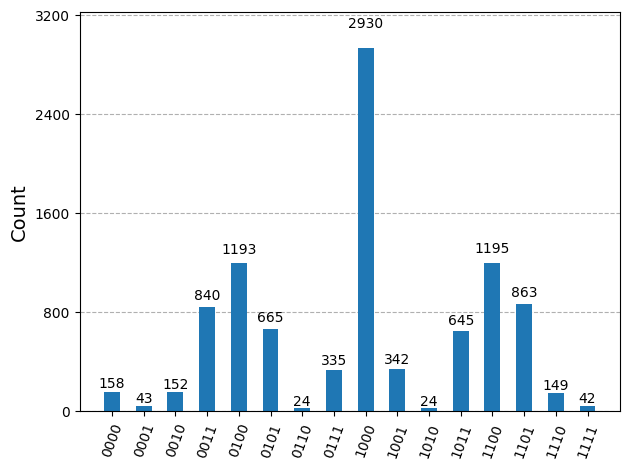

In [274]:
func_values = np.sin(8*x)  

# Normalize the values to fit as amplitudes
normalized_values = func_values / np.linalg.norm(func_values)
counts = convertor(n_qubits, normalized_values)
plot_histogram(counts)

4. The histogram for $sin(8x)$ shows expected peak at 8 but this the plot has a distict different pattern (small peaks at other frequencies). This was not observed for either $e^{2ix}$ or $sin(2x)$. There is a very profound reason for this, please do some detailed research on this (maybe you find some insights related to the core principles behind DFT itself, be it classical one or its quantum counterpart). Give a detailed explaination for this pattern (Please dont write due to error, we are using noiseless AerSimulator for this).


 a paper I read : https://arxiv.org/abs/2503.01545 (Limitations of Amplitude Encoding on Quantum Classification)

 Basically we encounter a bottleneck in the large $N$ cases due to arbitrary state preparation of an $n$-qubit amplitude encoded state 
Also, as given in the paper, in QML applications, it does not effectively reduce training loss (often times it increases training loss)

source : https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/qtc2.12032

1) Angle encoding : Integrates classical info in quantum states which makes it easier to handle classical data. One of the main advantage of angle embedding is that it can be performed in a constant time with parralelism : each qubit will go through a rotation gate in parralel.
2) QRAM encoding : Uses the classical RAM concept in the quantum sense. Using address and data qubits we can effectively carry out large processes. The main issue curently is handling the large amount of error overhead 

In [284]:
import base64

with open("theta.txt", "r") as f:
    encoded_theta = f.read()

theta = float(base64.b64decode(encoded_theta).decode())
phi = (2 * np.pi * theta) / 4
print(theta)
qc_qpe = QuantumCircuit(2)
qc_qpe.x(1)
power = 2
qc_qpe.cp(theta=2**power*2*np.pi*theta, control_qubit=0, target_qubit=1)

2.75


Here, we divide by 4 since we would lose the value of the eigenvalue due to periodicity of the euler form. Since it is periodic over $2\pi$ we need to scale the $\theta$ down by 4 to accurately depict its value

In [ ]:
def qpe_circuit(theta, n_counting_qubits=4):

    counting_qubits = QuantumRegister(n_counting_qubits, 'counting')
    target_qubit = QuantumRegister(1, 'target')
    classical_bits = ClassicalRegister(n_counting_qubits, 'classic')
    
    qc = QuantumCircuit(counting_qubits, target_qubit, classical_bits)
    qc.x(target_qubit[0])
    for i in range(n_counting_qubits):
        qc.h(counting_qubits[i])

    for j in range(n_counting_qubits):

        power = 2**j
        phase_angle = power * 2 * np.pi * theta / 4 
        qc.cp(phase_angle, counting_qubits[j], target_qubit[0])

    qft_inverse(qc, counting_qubits)
    qc.measure(counting_qubits, classical_bits)
    
    return qc

def qft_inverse(qc, qubits):

    n = len(qubits)
    
    # Apply inverse QFT
    for i in range(n//2):
        qc.swap(qubits[i], qubits[n-1-i])
    
    for i in range(n):
        for j in range(i):
            qc.cp(-np.pi/2**(i-j), qubits[j], qubits[i])
        qc.h(qubits[i])


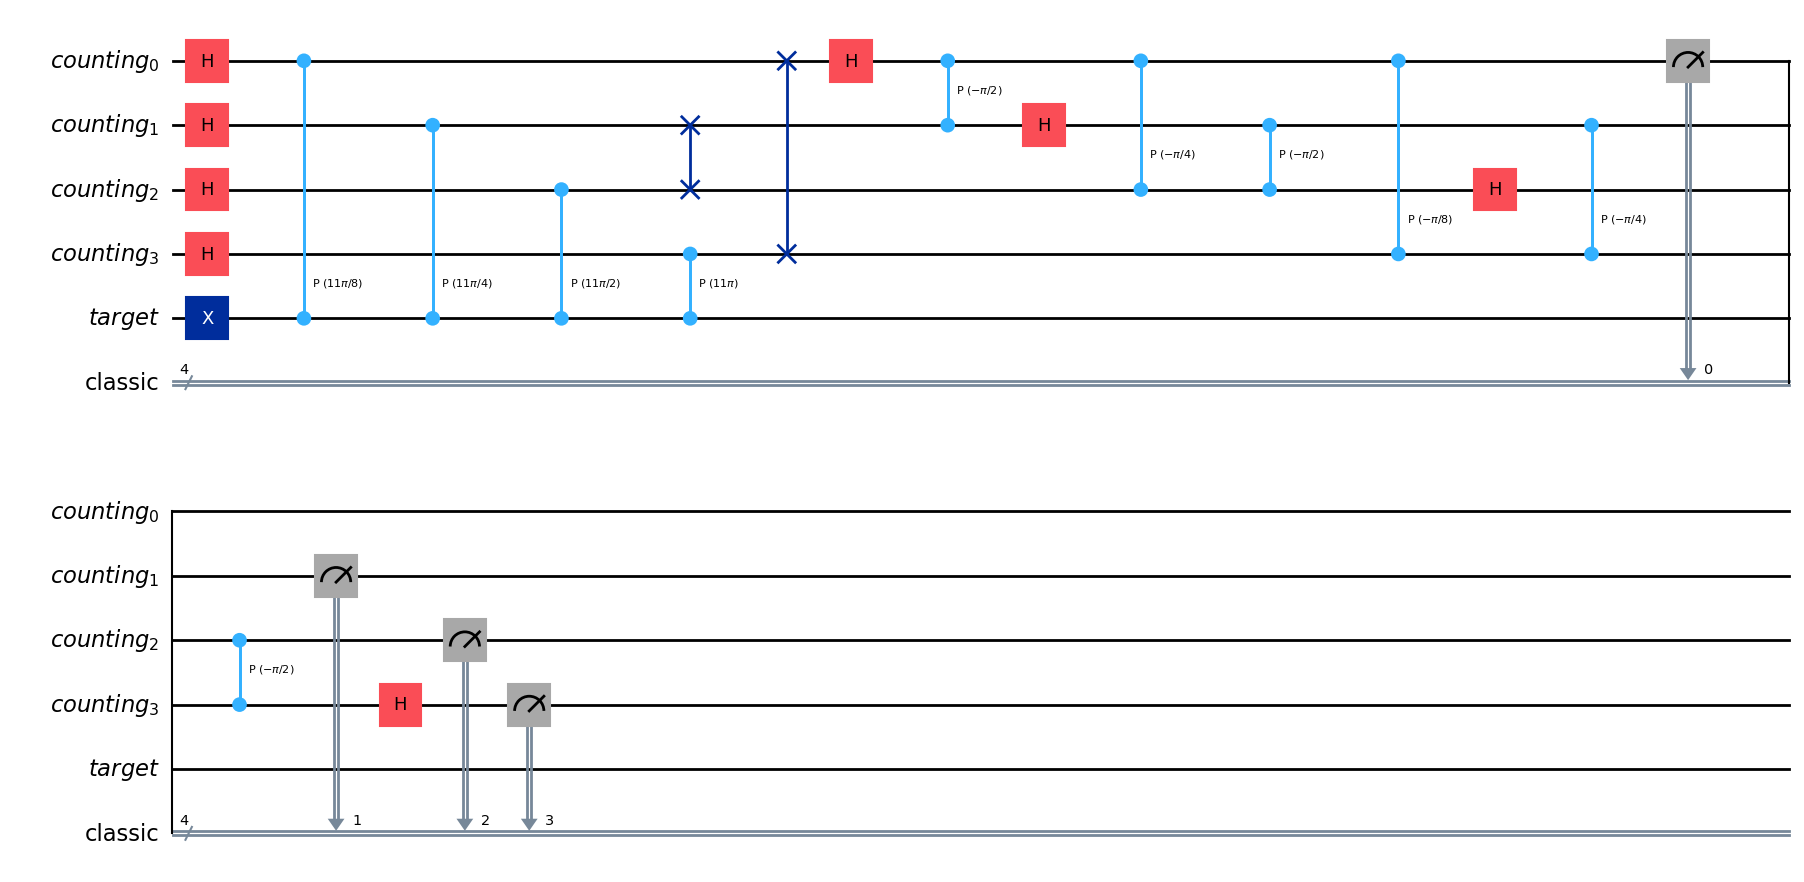

In [278]:
qc_qpe = qpe_circuit(theta, n_counting_qubits=4)
qc_qpe.draw('mpl')


In [279]:
simulator = AerSimulator()
pm = generate_preset_pass_manager(backend=simulator, optimization_level=1)
transpiled_qc = pm.run(qc_qpe)

job = simulator.run(transpiled_qc, shots=8192)
result = job.result()
counts = result.get_counts()
for bitstring, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{bitstring}: {count} )")

1011: 8192 )


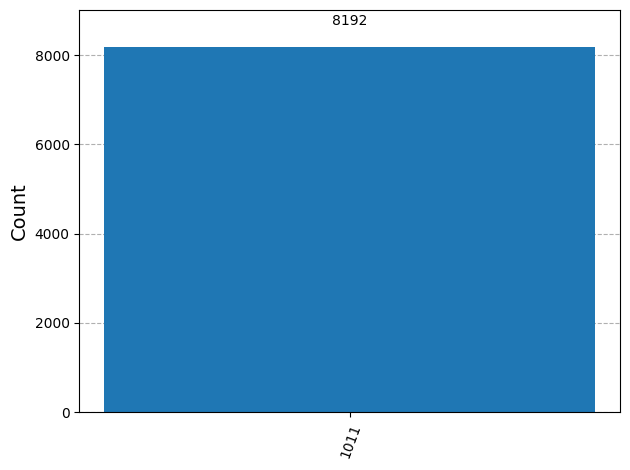

In [280]:
plot_histogram(counts)

In [281]:
most_frequent = max(counts, key=counts.get)
print(f"\nMost frequent measurement: {most_frequent}")

measured_phase = int(most_frequent, 2) / (2**4) 
estimated_theta = measured_phase * 4

print(f"First excited state energy: {estimated_theta} units")


Most frequent measurement: 1011
First excited state energy: 2.75 units


In [282]:
def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

def extended_gcd(a, b):
    if a == 0:
        return b, 0, 1
    gcd, x1, y1 = extended_gcd(b % a, a)
    x = y1 - (b // a) * x1
    y = x1
    return gcd, x, y

def mod_inverse(e, phi):
    gcd, x, _ = extended_gcd(e, phi)
    if gcd != 1:
        raise ValueError("no modular inverse")
    return x % phi

def classical_period_finding(a, N):
    period = 1
    current = a % N
    while current != 1:
        current = (current * a) % N
        period += 1
    return period

def shors_algorithm(N, a=None):
    
    if a is None:
        a = random.randint(2, N-1)
        while gcd(a, N) != 1:
            a = random.randint(2, N-1)
    
    print(f"Using a: {a}")
    
    g = gcd(a, N)
    if g > 1:
        print(f"gcd({a}, {N}) = {g}")
        return g, N // g
    
    n_qubits = math.ceil(math.log2(N)) 
    counting_qubits = 2 * n_qubits      
    
    counting_reg = QuantumRegister(counting_qubits, 'counting')
    work_reg = QuantumRegister(n_qubits, 'work')
    classical_reg = ClassicalRegister(counting_qubits, 'classic')
    
    qc = QuantumCircuit(counting_reg, work_reg, classical_reg)
    
    qc.h(counting_reg)
    
    qc.x(work_reg[0])   
    qc.barrier()
    
    qc.append(QFT(counting_qubits, inverse=True), counting_reg) 
    r = classical_period_finding(a, N)
    
    if r % 2 != 0:
        return shors_algorithm(N)  
    
    factor1 = gcd(pow(a, r//2) - 1, N)
    factor2 = gcd(pow(a, r//2) + 1, N)

    
    if factor1 > 1 and factor1 < N:
        p, q = factor1, N // factor1
        return p, q
    elif factor2 > 1 and factor2 < N:
        p, q = factor2, N // factor2
        return p, q
    else:
        return shors_algorithm(N)

def decrypt_message(ciphertext, d, N):
    plaintext = []
    for c in ciphertext:
        m = pow(c, d, N)
        plaintext.append(m)
    return plaintext

def numbers_to_letters(numbers):
    letters = []
    for num in numbers:
        if 1 <= num <= 14:
            letters.append(chr(ord('A') + num - 1))
        else:
            letters.append('?')
    return ''.join(letters)


In [283]:
N = 15
e = 7
ciphertext = [14, 9, 12, 5]
chosen_a = 7  


p, q = shors_algorithm(N, chosen_a)

phi_N = (p - 1) * (q - 1)

d = mod_inverse(e, phi_N)

plaintext_numbers = decrypt_message(ciphertext, d, N)
for i, (c, m) in enumerate(zip(ciphertext, plaintext_numbers)):
    print(f"c[{i}] = {c}: m = {c}^{d} mod {N} = {m}")

secret_word = numbers_to_letters(plaintext_numbers)

print(f"Decrypted word: {secret_word} ")

Using a: 7
c[0] = 14: m = 14^7 mod 15 = 14
c[1] = 9: m = 9^7 mod 15 = 9
c[2] = 12: m = 12^7 mod 15 = 3
c[3] = 5: m = 5^7 mod 15 = 5
Decrypted word: NICE 
